In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from pytorch_msssim import ms_ssim

# mps
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [12]:
import numpy as np
import torch.nn.functional as F
import torch

# === 1. 加载原始 HR 数据 ===
hr_train = np.load("tm/HR_data_train_tm.npy")[:200]
hr_valid = np.load("tm/HR_data_valid_tm.npy")[:200]
hr_test = np.load("tm/HR_data_test_tm.npy")[:200]

# === 2. 生成 LR 数据（双线性插值至 16×16） ===
def downsample(hr_array, scale=4):
    tensor = torch.tensor(hr_array, dtype=torch.float32)
    return F.interpolate(tensor, scale_factor=1/scale, mode="bilinear", align_corners=False).numpy()

lr_train = downsample(hr_train)
lr_valid = downsample(hr_valid)
lr_test = downsample(hr_test)

# === 3. 保存为 .npy 文件 ===
np.save("tm/HR_data_train_40.npy", hr_train)
np.save("tm/LR_data_train_40.npy", lr_train)
np.save("tm/HR_data_valid_40.npy", hr_valid)
np.save("tm/LR_data_valid_40.npy", lr_valid)
np.save("tm/HR_data_test_40.npy", hr_test)
np.save("tm/LR_data_test_40.npy", lr_test)

# === 4. 计算并保存 mean/std（仅用 HR_train）===
mean = np.mean(hr_train, axis=(0, 2, 3))[:, None, None]
std = np.std(hr_train, axis=(0, 2, 3))[:, None, None]
np.save("tm/mean_40.npy", mean)
np.save("tm/std_40.npy", std)

print("✅ 完成：生成 LR/HR 切片、保存归一化参数，包括 test")


✅ 完成：生成 LR/HR 切片、保存归一化参数，包括 test


In [13]:
class WeatherDataset(Dataset):
    def __init__(self, lr_path, hr_path, mean_path, std_path):
        self.lr = np.load(lr_path)
        self.hr = np.load(hr_path)
        self.mean = np.load(mean_path).reshape(2, 1, 1)
        self.std = np.load(std_path).reshape(2, 1, 1)

    def __len__(self):
        return len(self.lr)

    def __getitem__(self, idx):
        lr = (self.lr[idx] - self.mean) / self.std
        hr = (self.hr[idx] - self.mean) / self.std
        return torch.tensor(lr, dtype=torch.float32), torch.tensor(hr, dtype=torch.float32)


In [14]:
class SRResNetGenerator(nn.Module):
    def __init__(self, in_channels=2, out_channels=2, features=64):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features, kernel_size=9, padding=4),
            nn.PReLU()
        )

        # 8 Residual Blocks
        res_blocks = []
        for _ in range(8):
            res_blocks.append(nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3, padding=1),
                nn.BatchNorm2d(features),
                nn.PReLU(),
                nn.Conv2d(features, features, kernel_size=3, padding=1),
                nn.BatchNorm2d(features)
            ))
        self.res_blocks = nn.Sequential(*res_blocks)

        self.mid_conv = nn.Sequential(
            nn.Conv2d(features, features, kernel_size=3, padding=1),
            nn.BatchNorm2d(features)
        )

        self.upsample = nn.Sequential(
            nn.Conv2d(features, features * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(features, features * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.PReLU(),
        )

        self.final = nn.Sequential(
            nn.Conv2d(features, out_channels, kernel_size=9, padding=4),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.initial(x)
        res = x1
        for block in self.res_blocks:
            res = res + block(res)
        out = self.mid_conv(res)
        out = out + x1
        out = self.upsample(out)
        return self.final(out)


In [15]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, in_channels=4, features=64):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1),  # (B, 64, 32, 32)
            nn.LeakyReLU(0.2),
            nn.Conv2d(features, features * 2, 4, 2, 1),  # (B, 128, 16, 16)
            nn.BatchNorm2d(features * 2),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 2, features * 4, 4, 2, 1),  # (B, 256, 8, 8)
            nn.BatchNorm2d(features * 4),
            nn.LeakyReLU(0.2),
            nn.Conv2d(features * 4, 1, 4, 1, 1),  # (B, 1, 7, 7) => PatchGAN 输出
            nn.Sigmoid()
        )

    def forward(self, lr_up, hr_or_fake):
        # Ensure both inputs are [B, 2, 64, 64]
        if lr_up.shape[-2:] != hr_or_fake.shape[-2:]:
            raise ValueError(f"Shape mismatch: lr_up={lr_up.shape}, hr={hr_or_fake.shape}")
        x = torch.cat([lr_up, hr_or_fake], dim=1)  # => [B, 4, H, W]
        return self.model(x)


In [16]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import torch.nn.functional as F

def compute_psnr_ssim(pred, target):
    # shape(N, H, W, C)
    pred = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
    target = target.detach().cpu().numpy().transpose(0, 2, 3, 1)
    data_range = max(target.max(), pred.max()) - min(target.min(), pred.min())

    psnr_total, ssim_total = 0, 0
    for p, t in zip(pred, target):
        psnr_total += peak_signal_noise_ratio(t, p, data_range=data_range)
        ssim_total += structural_similarity(t, p, channel_axis=-1, data_range=data_range)
    return psnr_total / len(pred), ssim_total / len(pred)

def compute_rmse(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))

def compute_mae(pred, target):
    return torch.mean(torch.abs(pred - target))


# === 添加 SSIM Loss ===
def ssim_loss(pred, target, C1=0.01**2, C2=0.03**2):
    mu_x = F.avg_pool2d(pred, 3, 1, 1)
    mu_y = F.avg_pool2d(target, 3, 1, 1)
    sigma_x = F.avg_pool2d(pred ** 2, 3, 1, 1) - mu_x ** 2
    sigma_y = F.avg_pool2d(target ** 2, 3, 1, 1) - mu_y ** 2
    sigma_xy = F.avg_pool2d(pred * target, 3, 1, 1) - mu_x * mu_y
    ssim_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    ssim_d = (mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x + sigma_y + C2)
    ssim_map = ssim_n / (ssim_d + 1e-8)
    return 1 - ssim_map.mean()

# 加载 min/max（你刚才保存过）
hr_min = np.load("tm/min_40.npy")[:, None, None]
hr_max = np.load("tm/max_40.npy")[:, None, None]

def minmax_scale(tensor):
    # 缩放到 0~1
    return (tensor - torch.tensor(hr_min, dtype=torch.float32).to(tensor.device)) / \
           (torch.tensor(hr_max - hr_min, dtype=torch.float32).to(tensor.device))

In [17]:
def evaluate_on_loader(model, loader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for lr, hr in loader:
            lr, hr = lr.to(device), hr.to(device)
            pred = model(lr)
            pred = F.interpolate(pred, size=hr.shape[-2:], mode="bilinear", align_corners=False)
            preds.append(pred.cpu())
            targets.append(hr.cpu())
    preds = torch.cat(preds, dim=0)
    targets = torch.cat(targets, dim=0)
    return compute_psnr_ssim(preds, targets)


In [18]:
train_set = WeatherDataset(
    "tm/LR_data_train_40.npy", "tm/HR_data_train_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)
val_set = WeatherDataset(
    "tm/LR_data_valid_40.npy", "tm/HR_data_valid_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)
test_set = WeatherDataset(
    "tm/LR_data_test_40.npy", "tm/HR_data_test_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)

test_loader = DataLoader(test_set, batch_size=8, shuffle=False)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)


In [19]:
# === Gradient Difference Loss (GDL) ===
def gradient_difference_loss(fake, hr):
    grad_fake_x = torch.abs(fake[:, :, 1:, :] - fake[:, :, :-1, :])
    grad_fake_y = torch.abs(fake[:, :, :, 1:] - fake[:, :, :, :-1])
    
    grad_hr_x = torch.abs(hr[:, :, 1:, :] - hr[:, :, :-1, :])
    grad_hr_y = torch.abs(hr[:, :, :, 1:] - hr[:, :, :, :-1])
    
    loss_x = F.l1_loss(grad_fake_x, grad_hr_x)
    loss_y = F.l1_loss(grad_fake_y, grad_hr_y)
    
    return loss_x + loss_y

# === Charbonnier Loss ===
class CharbonnierLoss(torch.nn.Module):
    """Charbonnier Loss (L1-like but differentiable at zero)"""
    def __init__(self, epsilon=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, prediction, target):
        diff = prediction - target
        loss = torch.mean(torch.sqrt(diff ** 2 + self.epsilon ** 2))
        return loss

# 初始化 Charbonnier 损失
charbonnier_loss = CharbonnierLoss()

In [23]:
# === 6. Model Initialization ===
G = SRResNetGenerator().to(device)
D = Discriminator().to(device)
criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()
opt_G = torch.optim.Adam(G.parameters(), lr=1e-3, betas=(0.5, 0.999), weight_decay=1e-4)
opt_D = torch.optim.Adam(D.parameters(), lr=1e-3, betas=(0.5, 0.999), weight_decay=1e-4)
with torch.no_grad():
    dummy_input = torch.randn(1, 2, 16, 16).to(device)
    dummy_output = G(dummy_input)
    print(f"✅ G output shape: {dummy_output.shape}")  # 应该是 [1, 2, 64, 64]


✅ G output shape: torch.Size([1, 2, 64, 64])


In [24]:
# 初始化 Charbonnier 损失
charbonnier_loss = CharbonnierLoss()

# === Training Loop ===
num_epochs = 200
train_psnrs, train_ssims, train_rmses, train_maes = [], [], [], []
val_psnrs, val_ssims, val_rmses, val_maes = [], [], [], []

for epoch in range(num_epochs):
    G.train()
    for lr, hr in train_loader:
        lr, hr = lr.to(device), hr.to(device)

        # === Forward Generator ===
        fake = G(lr).to(device)
        lr_up = F.interpolate(lr, size=hr.shape[-2:], mode="bilinear", align_corners=False)

        # === Train Discriminator ===
        D_real = D(lr_up, hr).to(device)
        D_fake = D(lr_up, fake.detach()).to(device)
        loss_D = (
            criterion_GAN(D_real, torch.ones_like(D_real)) +
            criterion_GAN(D_fake, torch.zeros_like(D_fake))
        ) * 0.5
        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # === Train Generator ===
        pred = D(lr_up, fake)

        # === Compute All Losses ===
        loss_ssim = ssim_loss(fake, hr)                     # SSIM Loss
        loss_gdl = gradient_difference_loss(fake, hr)       # GDL Loss
        loss_charbonnier = charbonnier_loss(fake, hr)       # Charbonnier Loss
        loss_gan = criterion_GAN(pred, torch.ones_like(pred))  # GAN Loss

        # === Final Generator Loss (Weighted Sum) ===
        loss_G = (
            0.01 * loss_gan +             # GAN Loss (对抗学习)
            1.0 * loss_ssim +             # SSIM (结构相似)
            0.5 * loss_gdl +              # GDL (梯度差异)
            1.0 * loss_charbonnier        # Charbonnier (平滑差异)
        )

        # === Backpropagation ===
        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    # === Evaluation Phase ===
    train_pred = G(lr)
    train_pred = F.interpolate(train_pred, size=hr.shape[-2:], mode="bilinear", align_corners=False).to(device)
    # 评估
    train_pred_mm = minmax_scale(train_pred)
    hr_mm = minmax_scale(hr)
    psnr_train, ssim_train = compute_psnr_ssim(train_pred, hr)
    rmse_train = compute_rmse(train_pred_mm, hr_mm)
    mae_train = compute_mae(train_pred_mm, hr_mm)

    train_psnrs.append(psnr_train)
    train_ssims.append(ssim_train)
    train_rmses.append(rmse_train)
    train_maes.append(mae_train)

    # === Validation Phase ===
    G.eval()
    with torch.no_grad():
        val_lr, val_hr = next(iter(val_loader))
        val_lr, val_hr = val_lr.to(device), val_hr.to(device)
        pred_hr = G(val_lr)
        pred_hr = F.interpolate(pred_hr, size=val_hr.shape[-2:], mode="bilinear", align_corners=False).to(device)

        pred_val_mm = minmax_scale(pred_hr)
        val_hr_mm = minmax_scale(val_hr)
        psnr_val, ssim_val = compute_psnr_ssim(pred_hr, val_hr)
        rmse_val = compute_rmse(pred_val_mm, val_hr_mm)
        mae_val = compute_mae(pred_val_mm, val_hr_mm)

        val_psnrs.append(psnr_val)
        val_ssims.append(ssim_val)
        val_rmses.append(rmse_val)
        val_maes.append(mae_val)

    # === Print summary ===
    print(f"Epoch {epoch+1}: "
          f"Train PSNR={psnr_train:.2f}, SSIM={ssim_train:.4f}, RMSE={rmse_train:.4f}, MAE={mae_train:.4f} | "
          f"Valid PSNR={psnr_val:.2f}, SSIM={ssim_val:.4f}, RMSE={rmse_val:.4f}, MAE={mae_val:.4f}")
    
# ==== 保存模型 ====
torch.save(G.state_dict(), "G_origin.pth")
print("✅ 模型保存至 G_origin.pth")

Epoch 1: Train PSNR=18.66, SSIM=0.3768, RMSE=0.0068, MAE=0.0039 | Valid PSNR=17.81, SSIM=0.4000, RMSE=0.0114, MAE=0.0058
Epoch 2: Train PSNR=23.32, SSIM=0.5282, RMSE=0.0075, MAE=0.0038 | Valid PSNR=21.15, SSIM=0.5538, RMSE=0.0113, MAE=0.0057
Epoch 3: Train PSNR=23.50, SSIM=0.5156, RMSE=0.0074, MAE=0.0038 | Valid PSNR=21.04, SSIM=0.5157, RMSE=0.0112, MAE=0.0057
Epoch 4: Train PSNR=23.95, SSIM=0.6016, RMSE=0.0067, MAE=0.0036 | Valid PSNR=21.30, SSIM=0.6068, RMSE=0.0117, MAE=0.0061
Epoch 5: Train PSNR=23.96, SSIM=0.5672, RMSE=0.0069, MAE=0.0038 | Valid PSNR=21.52, SSIM=0.5915, RMSE=0.0113, MAE=0.0059
Epoch 6: Train PSNR=24.94, SSIM=0.7206, RMSE=0.0051, MAE=0.0026 | Valid PSNR=21.96, SSIM=0.7264, RMSE=0.0111, MAE=0.0053
Epoch 7: Train PSNR=24.72, SSIM=0.7548, RMSE=0.0068, MAE=0.0034 | Valid PSNR=21.82, SSIM=0.7327, RMSE=0.0114, MAE=0.0057
Epoch 8: Train PSNR=25.48, SSIM=0.7983, RMSE=0.0056, MAE=0.0027 | Valid PSNR=22.08, SSIM=0.7740, RMSE=0.0112, MAE=0.0052
Epoch 9: Train PSNR=26.08, SSIM=

KeyboardInterrupt: 

In [25]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# ==== 保存模型 ====
torch.save(G.state_dict(), "G_final.pth")
print("✅ 模型保存至 G_final.pth")


# === 1. 加载测试集 ===
test_set = WeatherDataset(
    "tm/LR_data_test_40.npy", "tm/HR_data_test_40.npy",
    "tm/mean_40.npy", "tm/std_40.npy"
)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False)

# === 2. 在测试集上评估模型 ===
G = SRResNetGenerator().to(device)
G.load_state_dict(torch.load("G_final.pth"))
G.eval()
test_psnrs, test_ssims, test_rmses, test_maes = [], [], [], []
images_to_show = []  # 原图、真实图、预测图（反归一化后）

# 反归一化函数
mean = np.load("tm/mean_40.npy")
std = np.load("tm/std_40.npy")
def denormalize(tensor):
    return tensor * torch.tensor(std).to(tensor.device) + torch.tensor(mean).to(tensor.device)

with torch.no_grad():
    for test_lr, test_hr in test_loader:
        test_lr, test_hr = test_lr.to(device), test_hr.to(device)
        pred_test = G(test_lr)
        pred_test = F.interpolate(pred_test, size=test_hr.shape[-2:], mode="bilinear", align_corners=False)

        # 计算指标（归一化下）
        pred_mm = minmax_scale(pred_test)
        hr_mm = minmax_scale(test_hr)
        psnr, ssim = compute_psnr_ssim(pred_test, test_hr)
        rmse = compute_rmse(pred_mm, hr_mm)
        mae = compute_mae(pred_mm, hr_mm)
        test_psnrs.append(psnr)
        test_ssims.append(ssim)
        test_rmses.append(rmse.cpu().item())
        test_maes.append(mae.cpu().item())

        # 可视化：选取前1张图，反归一化
        for i in range(1):
            lr_img = F.interpolate(test_lr[i:i+1], size=(64, 64), mode="bilinear", align_corners=False)
            images_to_show.append((
                denormalize(lr_img[0].cpu()),
                denormalize(test_hr[i].cpu()),
                denormalize(pred_test[i].cpu())
            ))

# === 3. 打印测试集平均指标 ===
print(f"Test Set Evaluation for SRGAN:")
print(f"PSNR: {np.mean(test_psnrs):.2f}")
print(f"SSIM: {np.mean(test_ssims):.4f}")
print(f"RMSE: {np.mean(test_rmses):.4f}")
print(f"MAE: {np.mean(test_maes):.4f}")


✅ 模型保存至 G_final.pth


/var/folders/4p/p5h6h2t5317gljf_p2xg65wc0000gn/T/ipykernel_57809/4006500988.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("G_final.pth"))

Test Set Evaluation for SRGAN:
PSNR: 23.39
SSIM: 0.8300
RMSE: 0.0086
MAE: 0.0041


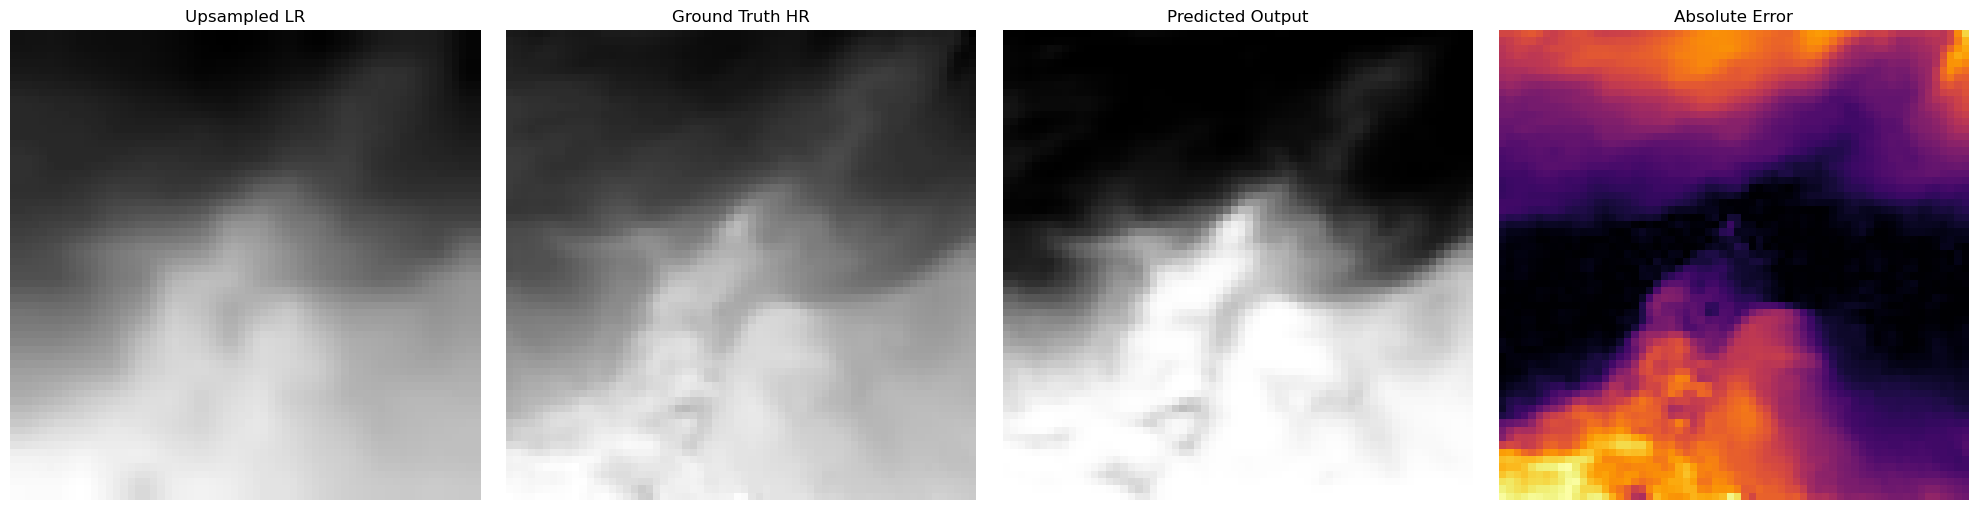

In [14]:
import matplotlib.pyplot as plt

# ========== 设置模型为评估模式 ==========
G.eval()
with torch.no_grad():
    # 获取测试集的第一个 batch
    test_lr, test_hr = next(iter(train_loader))
    test_lr, test_hr = test_lr.to(device), test_hr.to(device)

    # 生成模型输出
    generated_output = G(test_lr)
    generated_output = F.interpolate(generated_output, size=test_hr.shape[-2:], mode="bilinear", align_corners=False)

    # 反归一化
    mean = torch.tensor(np.load("tm/mean_40.npy"), dtype=torch.float32).view(2, 1, 1).to(device)
    std = torch.tensor(np.load("tm/std_40.npy"), dtype=torch.float32).view(2, 1, 1).to(device)

    def denormalize(tensor):
        return tensor * std + mean

    test_lr_denorm = F.interpolate(test_lr, size=(64, 64), mode="bilinear", align_corners=False)
    lr_img = denormalize(test_lr_denorm[0]).cpu().numpy().transpose(1, 2, 0)
    hr_img = denormalize(test_hr[0]).cpu().numpy().transpose(1, 2, 0)
    pred_img = denormalize(generated_output[0]).cpu().numpy().transpose(1, 2, 0)

    abs_error = np.abs(pred_img - hr_img)

    # ========== 可视化图像 ==========
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    axs[0].imshow(lr_img[:, :, 0], cmap='gray')  # 可改为取其他通道或显示 RGB
    axs[0].set_title("Upsampled LR")
    axs[0].axis("off")

    axs[1].imshow(hr_img[:, :, 0], cmap='gray')
    axs[1].set_title("Ground Truth HR")
    axs[1].axis("off")

    axs[2].imshow(pred_img[:, :, 0], cmap='gray')
    axs[2].set_title("Predicted Output")
    axs[2].axis("off")

    axs[3].imshow(abs_error[:, :, 0], cmap='inferno')
    axs[3].set_title("Absolute Error")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()


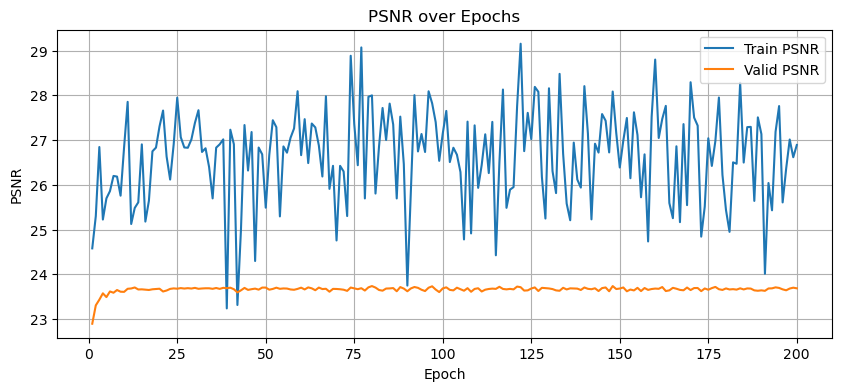

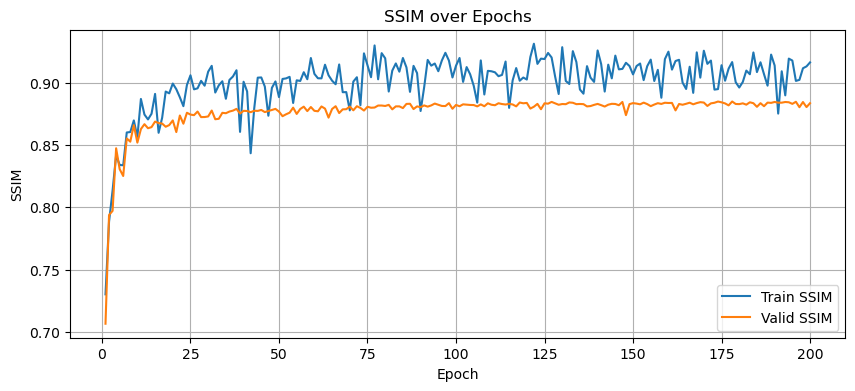

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_psnrs)+1))

# === PSNR ===
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_psnrs, label="Train PSNR")
plt.plot(epochs, val_psnrs, label="Valid PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR")
plt.title("PSNR over Epochs")
plt.legend()
plt.grid(True)
plt.show()
# === SSIM ===
plt.figure(figsize=(10, 4))
plt.plot(epochs, train_ssims, label="Train SSIM")
plt.plot(epochs, val_ssims, label="Valid SSIM")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.title("SSIM over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
import numpy as np

# 将数组保存为 .npy 文件
np.save("o_ssim_train.npy", train_ssims)
np.save("o_psnr_train.npy", train_psnrs)
np.save("o_ssim_valid.npy", val_ssims)
np.save("o_psnr_valid.npy", val_psnrs)

print("✅ 已保存为 2_ssim_train.npy, 2_psnr_train.npy, 2_ssim_valid.npy, 2_psnr_valid.npy")


✅ 已保存为 2_ssim_train.npy, 2_psnr_train.npy, 2_ssim_valid.npy, 2_psnr_valid.npy


In [14]:
# 确保每个 tensor 都通过 .detach() 断开计算图，之后转移到 CPU 并转换为 NumPy 数组
train_maes_cpu = [mae.detach().cpu().numpy() for mae in train_maes]
train_rmses_cpu = [rmse.detach().cpu().numpy() for rmse in train_rmses]

# 保存为 .npy 文件
np.save("o_mae_train.npy", train_maes_cpu)
np.save("o_rmes_train.npy", train_rmses_cpu)


In [15]:
# 确保每个 tensor 都通过 .detach() 断开计算图，之后转移到 CPU 并转换为 NumPy 数组
valid_maes_cpu = [mae.detach().cpu().numpy() for mae in val_maes]
valid_rmses_cpu = [rmse.detach().cpu().numpy() for rmse in val_rmses]

# 保存为 .npy 文件
np.save("o_mae_valid.npy", valid_maes_cpu)
np.save("o_rmes_valid.npy", valid_rmses_cpu)


In [24]:
import numpy as np
import pandas as pd

# .npy 文件的列表
files = [
    "2_mae_train.npy", "2_mae_valid.npy", 
    "2_psnr_train.npy", "2_psnr_valid.npy",
    "2_rmes_train.npy", "2_rmes_valid.npy",
    "2_ssim_train.npy", "2_ssim_valid.npy"
]

# 创建一个字典来存储数据
data_dict = {}

# 加载每个 .npy 文件并存入字典
for file in files:
    data_dict[file] = np.load(file)

# 将字典转换为 pandas DataFrame
df = pd.DataFrame(data_dict)

# 将 DataFrame 保存为 CSV 文件
df.to_csv("metrics_data.csv", index=False)
